In [2]:
import os
import pickle
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [3]:
action_classes = [
    'drink water', 'eat meal/snack', 'brushing teeth', 'brushing hair', 'drop', 'pickup', 'throw', 'sitting down',
    'standing up (from sitting position)', 'clapping', 'reading', 'writing', 'tear up paper', 'wear jacket',
    'take off jacket', 'wear a shoe', 'take off a shoe', 'wear on glasses', 'take off glasses', 'put on a hat/cap',
    'take off a hat/cap', 'cheer up', 'hand waving', 'kicking something', 'reach into pocket', 'hopping (one foot jumping)',
    'jump up', 'make a phone call/answer phone', 'playing with phone/tablet', 'typing on a keyboard',
    'pointing to something with finger', 'taking a selfie', 'check time (from watch)', 'rub two hands together',
    'nod head/bow', 'shake head', 'wipe face', 'salute', 'put palms together', 'cross hands in front',
    'sneeze/cough', 'staggering', 'falling', 'touch head (headache)', 'touch chest (stomachache/heart pain)',
    'touch back (backache)', 'touch neck (neckache)', 'nausea or vomiting condition', 'use a fan (with hand or paper)/feeling warm',
    'punching/slapping other person', 'kicking other person', 'pushing other person', 'pat on back of other person',
    'point finger at the other person', 'hugging other person', 'giving something to other person', 'touch other person\'s pocket',
    'handshaking', 'walking towards each other', 'walking apart from each other'
]

idx_to_class = [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
    23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
    44, 45, 46, 47, 48, 49, 50,  51, 52, 53, 54, 55, 56, 57, 58, 59, 60
]


In [4]:
npz_data = np.load("gendata/ntu/NTU60_XSub.npz")

In [7]:
npz_data['x_train'].shape

(40091, 300, 150)

In [10]:
sample = npz_data['x_train'][125][0]

In [11]:
sample

array([-0.00622818, -0.23957929,  0.05726194,  0.        ,  0.        ,
        0.        ,  0.0035157 ,  0.23497692, -0.06687403, -0.03570837,
        0.3502768 , -0.07028604, -0.09130435,  0.18819311,  0.04849792,
       -0.12863274,  0.26432902, -0.10384297, -0.12709065,  0.06682241,
       -0.01319909, -0.10111414,  0.04479611, -0.02262998,  0.06933369,
        0.11607769, -0.14855504,  0.07762758, -0.09723715, -0.14437199,
        0.03635132, -0.2660842 , -0.14333296,  0.02381628, -0.331009  ,
       -0.12316203, -0.04394345, -0.23080121,  0.0658021 , -0.04426221,
       -0.5118348 ,  0.173949  ,  0.03374418, -0.86016655,  0.276345  ,
        0.07666251, -0.9482026 ,  0.22097898,  0.03177993, -0.24770322,
       -0.01119709,  0.07562105, -0.59380376,  0.04211998,  0.11242824,
       -0.9170419 ,  0.1716001 ,  0.04644871, -0.96098554,  0.10144591,
        0.00281848,  0.17672962, -0.04851198, -0.10606435,  0.00967331,
       -0.03350687, -0.10905075,  0.05417441, -0.01404905,  0.00

In [21]:
data = npz_data['x_train']
label = np.where(npz_data['y_train'] > 0)[1]

In [22]:
data.shape, label.shape

((40091, 300, 150), (40091,))

In [25]:
N, T, _ = data.shape
N,T

(40091, 300)

In [34]:
# N x C x T x V x M
data_reshaped = data.reshape((N,T,2,25,3)).transpose(0, 4, 1, 3, 2)
data_reshaped.shape

(40091, 3, 300, 25, 2)

In [44]:
from feeders.feeder_ntu import Feeder

feeder_dataset = Feeder(data_path="gendata/ntu/NTU60_XSub.npz",
                        split='train',
                        window_size=120,
                        p_interval=[0.5, 1])

In [195]:
feeder_test_dataset = Feeder(data_path="gendata/ntu/NTU60_XSub.npz",
                        split='test',
                        window_size=120,
                        p_interval=[0.5, 1])

In [52]:
f_data, f_label, f_idx = feeder_dataset[180]
f_data.shape, f_label, f_idx

((3, 120, 25, 2), 0, 180)

In [91]:
C, T, V , M = feeder_dataset[0][0].shape
feeder_reshaped_sample = feeder_dataset[0][0].reshape(M,T,V,C)
feeder_reshaped_sample[0][0][:,:2]

array([[-0.01345021,  0.        ],
       [ 0.        ,  0.0136762 ],
       [-0.0193581 ,  0.        ],
       [ 0.        , -0.12944001],
       [-0.1180291 ,  0.        ],
       [ 0.        ,  0.111351  ],
       [ 0.18674909,  0.        ],
       [ 0.        , -0.1150633 ],
       [-0.06840201,  0.        ],
       [ 0.        ,  0.00889769],
       [-0.03880981,  0.        ],
       [ 0.        ,  0.07632349],
       [ 0.11270039,  0.        ],
       [ 0.        ,  0.01053399],
       [-0.13283941,  0.        ],
       [ 0.        , -0.14576699],
       [-0.1226586 ,  0.        ],
       [ 0.        ,  0.00051617],
       [ 0.01366942,  0.        ],
       [ 0.        , -0.12019164],
       [-0.13027559,  0.        ],
       [ 0.        , -0.12409762],
       [ 0.11129755,  0.        ],
       [ 0.        , -0.04957451],
       [-0.10912628,  0.        ]], dtype=float32)

In [222]:
from typing import List, Dict
import matplotlib.pyplot as plt

def display_random_skeletons(dataset: torch.utils.data.Dataset,
                          classes: List[str],
                          n: int=10,
                          display_shape: bool=True,
                          seed: int=None):
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    if seed:
      random.seed(seed)

    random_samples_idx = random.sample(range(len(dataset)), k=n)
    # colors = ['g', 'g', 'g', 'g', 'b', 'b', 'b', 'b', 'r', 'r', 'r', 'r', 'c', 'c', 'c', 'c', 'm', 'm',
    #                       'm', 'm', 'g', 'b', 'b', 'r', 'r']
    
    plt.figure(figsize=(32,8))

    for i, targ_sample in enumerate(random_samples_idx):
        
        C, T, V, M = dataset[targ_sample][0].shape
        targ_keypoint, targ_label = dataset[targ_sample][0].reshape(M,T,V,C), dataset[targ_sample][1]

        random_frame_idx = random.choice(range(targ_keypoint[0].shape[0]))
        # targ_keypoint, targ_label = dataset[targ_sample][keypoint], dataset[targ_sample]['label']

        x = targ_keypoint[0][random_frame_idx][:,0]
        y = targ_keypoint[0][random_frame_idx][:,1]

        action_label = action_classes[targ_label]
        plt.subplot(1,n,i+1)
        plt.scatter(x, y, color='r')
        plt.xlim([np.amin(targ_keypoint[0][:,:,0]), np.amax(targ_keypoint[0][:,:,0])])
        plt.ylim([np.amin(targ_keypoint[0][:,:,1]), np.amax(targ_keypoint[0][:,:,1])])
        # plt.xlim([-1, 1])
        # plt.ylim([-1, 1])
                
        # plt.axis(False)
        if classes:
            title = f"Class: {action_label}"
            if display_shape:
                title = title + f"\nSample number: {targ_sample}, total lengh: {targ_keypoint[0].shape[0]} frame: {random_frame_idx}"

        plt.title(title)

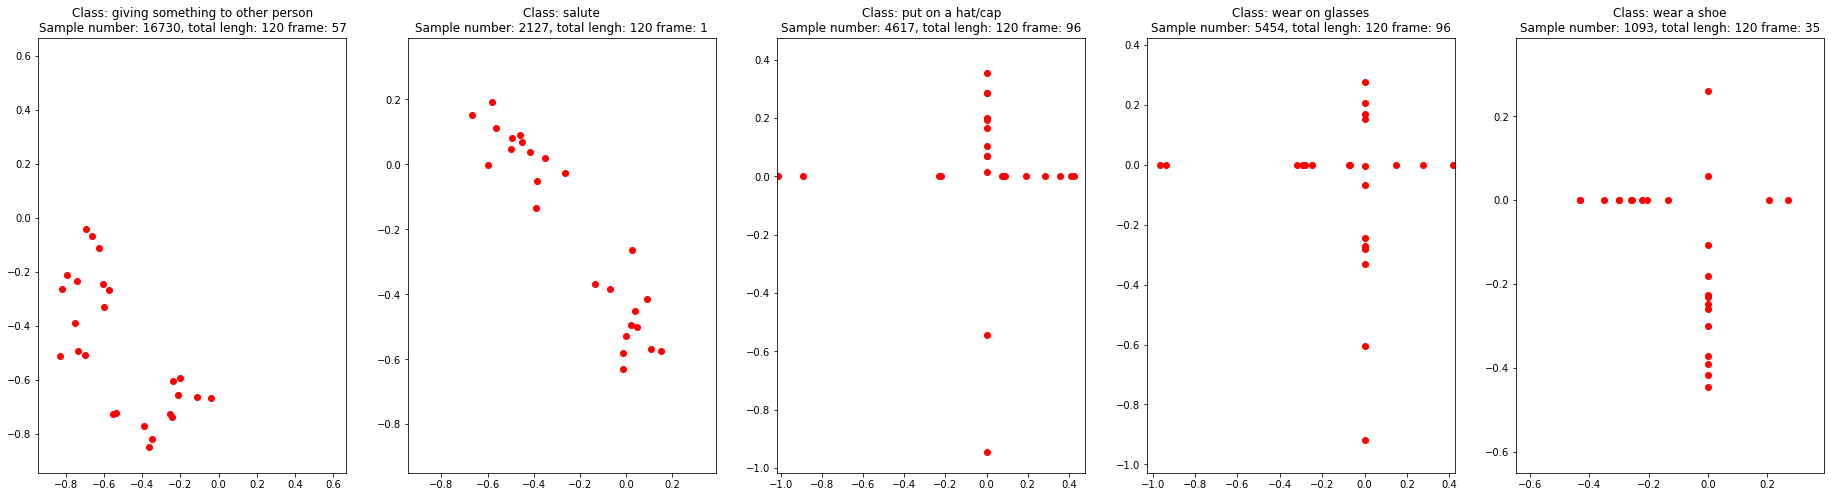

In [112]:
display_random_skeletons(dataset=feeder_dataset,
                         classes=action_classes,
                         n=5,
                         display_shape=True,
                         seed=None)

In [218]:
from model.sttformer import Model
output_device = 1 # GPU device

config = [[64,  64,  16], [64,  64,  16], 
           [64,  128, 32], [128, 128, 32],
           [128, 256, 64], [256, 256, 64], 
           [256, 256, 64], [256, 256, 64]]

sttformer_model = Model(len_parts=6,
              num_frames=120,
              num_joints=25,
              num_classes=60,
              num_heads=3,
              num_channels=3,
              num_persons=2,
              kernel_size=[3,5],
              use_pes=True,
              config=config).cuda(output_device)

sttformer_model


Model(
  (input_map): Sequential(
    (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (blocks): ModuleList(
    (0): STA_Block(
      (pes): Pos_Embed()
      (to_qkvs): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1))
      (out_nets): Sequential(
        (0): Conv2d(192, 64, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (ff_net): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (out_nett): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (tan): Tanh()
      (

In [205]:
from torchinfo import summary
summary(sttformer_model, input_size=[64, 3, 120, 25, 2])

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [64, 60]                  --
├─Sequential: 1-1                        [128, 64, 20, 150]        --
│    └─Conv2d: 2-1                       [128, 64, 20, 150]        256
│    └─BatchNorm2d: 2-2                  [128, 64, 20, 150]        128
│    └─LeakyReLU: 2-3                    [128, 64, 20, 150]        --
├─ModuleList: 1-2                        --                        --
│    └─STA_Block: 2-4                    [128, 64, 20, 150]        67,503
│    │    └─Pos_Embed: 3-1               [1, 64, 20, 150]          --
│    │    └─Conv2d: 3-2                  [128, 96, 20, 150]        6,240
│    │    └─Tanh: 3-3                    [128, 3, 150, 150]        --
│    │    └─Dropout: 3-4                 [128, 3, 150, 150]        --
│    │    └─Sequential: 3-5              [128, 64, 20, 150]        61,632
│    │    └─LeakyReLU: 3-6               [128, 64, 20, 150]        --
│ 

In [130]:
# Forward pass
pred = sttformer_model(feeder_X)

In [229]:
learning_rate = 0.1
weight_decay = 0.0004
loss_fn = nn.CrossEntropyLoss().cuda(output_device)
optimizer = optim.SGD(sttformer_model.parameters(),
                      lr=learning_rate,
                      momentum=0.9,
                      nesterov=True,
                      weight_decay=weight_decay)

In [186]:
warm_up_epoch = 5
step = [60, 80]
def adjust_learning_rate(epoch, learning_rate, warm_up_epoch, weight_decay, step, optimizer):
    print(f"adjust learning rate, using warm up, epoch: {warm_up_epoch}")
    if epoch < warm_up_epoch:
        lr = learning_rate * (epoch + 1) / warm_up_epoch
    else:
        lr = learning_rate * ( weight_decay ** np.sum(epoch >= np.array(step)))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr


In [175]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
learning_rate = adjust_learning_rate(epoch, learning_rate=learning_rate,
                         warm_up_epoch=warm_up_epoch,
                         weight_decay=weight_decay,
                         step=step,
                         optimizer=optimizer)


In [220]:
### Training step
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=output_device):
    train_loss, train_acc = 0, 0

    model.train()
    
    for batch, (X, y, idx) in enumerate(dataloader):
        with torch.no_grad():
            X = X.float().cuda(output_device)
            y = y.long().cuda(output_device)
        
        # Forward pass
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)
    
    # Adjust metrics to get average los and accuracy 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc        

In [191]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=output_device):
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y, idx) in enumerate(dataloader):
            X, y = X.float().cuda(output_device), y.long().cuda(output_device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += (y_pred_class==y).sum().item()/len(y_pred)
    
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [193]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=output_device):
    
    results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}
  
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        device=device)
        
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}, lr: {learning_rate} ")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    
    return results

In [227]:
feeder_dataloader = DataLoader(dataset=feeder_dataset,
                               batch_size=64,
                               shuffle=True,
                               drop_last=True,
                               num_workers=os.cpu_count())
feeder_dataloader

In [228]:
feeder_test_dataloader = DataLoader(dataset=feeder_test_dataset,
                               batch_size=64,
                               drop_last=True,
                               num_workers=os.cpu_count())
feeder_test_dataloader

In [ ]:
for batch, (_,_,_) in enumerate(feeder_test_dataloader)

In [198]:
feeder_X, feeder_y, feeder_idx = next(iter(feeder_test_dataloader))

In [230]:
learning_rate = 0.1
weight_decay = 0.0004
loss_fn = nn.CrossEntropyLoss().cuda(output_device)
optimizer = optim.SGD(sttformer_model.parameters(),
                      lr=learning_rate,
                      momentum=0.9,
                      nesterov=True,
                      weight_decay=weight_decay)

In [231]:
from timeit import default_timer as timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)

num_epochs = 6

start_time = timer()

# Train model_0
model_0_results = train(model=sttformer_model,
                        train_dataloader=feeder_dataloader,
                        test_dataloader=feeder_test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=num_epochs,
                        device=output_device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 2.6084 | Train acc: 0.2760 | Test loss: 1.9985 | Test acc: 0.4037, lr: 0.1 
Epoch: 1 | Train loss: 1.6174 | Train acc: 0.5067 | Test loss: 1.9675 | Test acc: 0.4863, lr: 0.1 
Epoch: 2 | Train loss: 1.3129 | Train acc: 0.5914 | Test loss: 1.6747 | Test acc: 0.5183, lr: 0.1 
Epoch: 3 | Train loss: 1.1470 | Train acc: 0.6443 | Test loss: 1.4925 | Test acc: 0.5545, lr: 0.1 
Epoch: 4 | Train loss: 1.0258 | Train acc: 0.6794 | Test loss: 1.3592 | Test acc: 0.6090, lr: 0.1 
Epoch: 5 | Train loss: 0.9297 | Train acc: 0.7102 | Test loss: 1.1807 | Test acc: 0.6541, lr: 0.1 
Total training time: 4160.488 seconds


In [223]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """
  Plots training curves of a results doctionary.
  """
  # Get the loss valurs of the results dict
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15,7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs,loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1,2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


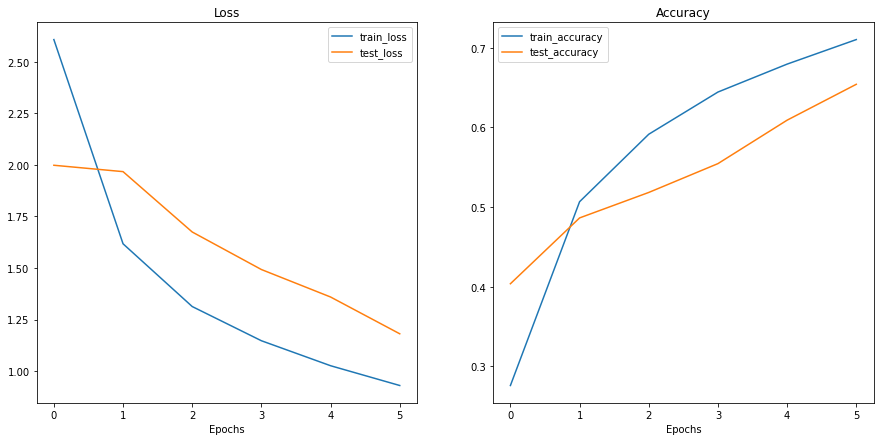

In [232]:
plot_loss_curves(model_0_results)

In [1]:
from pathlib import Path
import datetime


# Create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# Create model save
MODEL_NAME = f"sttformer_model_{timestamp}.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=sttformer_model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/sttformer_model_2023-05-02_00-08-26.pth


NameError: name 'torch' is not defined